Using the auction data from eBay to predict the future auction's success and deal prices 

NYU offered the source data,you can access the data through https://cims.nyu.edu/~munoz/data/  

In [14]:
import pandas as pd
from pandas import  DataFrame
import numpy as np
%matplotlib inline
from matplotlib import  pyplot as plt
import seaborn as sns


Read Data

In [15]:
test_set = pd.read_csv('raw/TestSet.csv')
train_set = pd.read_csv('raw/TrainingSet.csv')
test_subset = pd.read_csv('raw/TestSubset.csv')
train_subset = pd.read_csv('raw/TrainingSubset.csv')

In [16]:
train_set.info()
train_set.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258588 entries, 0 to 258587
Data columns (total 28 columns):
EbayID                     258588 non-null int64
QuantitySold               258588 non-null int64
Price                      258588 non-null float64
PricePercent               258588 non-null float64
StartingBidPercent         258588 non-null float64
SellerName                 258588 non-null object
SellerClosePercent         258588 non-null float64
Category                   258588 non-null int64
PersonID                   258588 non-null int64
StartingBid                258588 non-null float64
AvgPrice                   258588 non-null float64
EndDay                     258588 non-null object
HitCount                   258588 non-null int64
AuctionAvgHitCount         258588 non-null int64
ItemAuctionSellPercent     258588 non-null int64
SellerSaleAvgPriceRatio    258588 non-null float64
SellerAvg                  258588 non-null float64
SellerItemAvg              258588 non-

EbayID  QuantitySold  Price  PricePercent  StartingBidPercent  \
0  160983189073             1  27.25        1.4787              0.0537   
1  390549601720             1  43.00        1.4422              0.3350   
2  200901284676             1  11.00        0.5969              0.5426   
3  271162670857             0  10.00        0.5426              0.5426   
4  310611578768             0   9.99        1.9159              1.9159   

          SellerName  SellerClosePercent  Category  PersonID  StartingBid  \
0          petesandi            0.925926     73396      9174         0.99   
1         graphn4fun            0.990566     27278     11046         9.99   
2      hondo19461946            0.422131     73396      9174        10.00   
3        winemeyer45            0.245098     73396      9174        10.00   
4  chucksmemorabilia            0.295359     73396     17956         9.99   

          ...          AuctionHitCountAvgRatio BestOffer  ReturnsAccepted  \
0         ...                               29  1.540541                0   
1         ...                               55  0.404762                0   
2         ...                               21  0.324324                0   
3         ...                               26  0.270270                0   
4         ...                               53  0.200000                0   

   IsHOF  ItemListedCount  AuctionCount  AuctionSaleCount  SellerAuctionCount  \
0      1                1           583               291                  54   
1      0                0           120                43                 106   
2      1                1           583               291                 244   
3      0                1           583               291                 102   
4      1                0           137                44                 237   

   SellerAuctionSaleCount  AuctionMedianPrice  
0                      50               12.26  
1                     105               24.45  
2                     103               12.26  
3                      25               12.26  
4                      70                3.02  

[5 rows x 28 columns]

In [55]:
train = train_set.drop(['EbayID','QuantitySold','SellerName','EndDay'], axis=1)
train_target = train_set['QuantitySold']

# Gain the number of features 
_,n_features = train.shape
print(n_features)

24


Customers' private information and ID are useless for prediction 

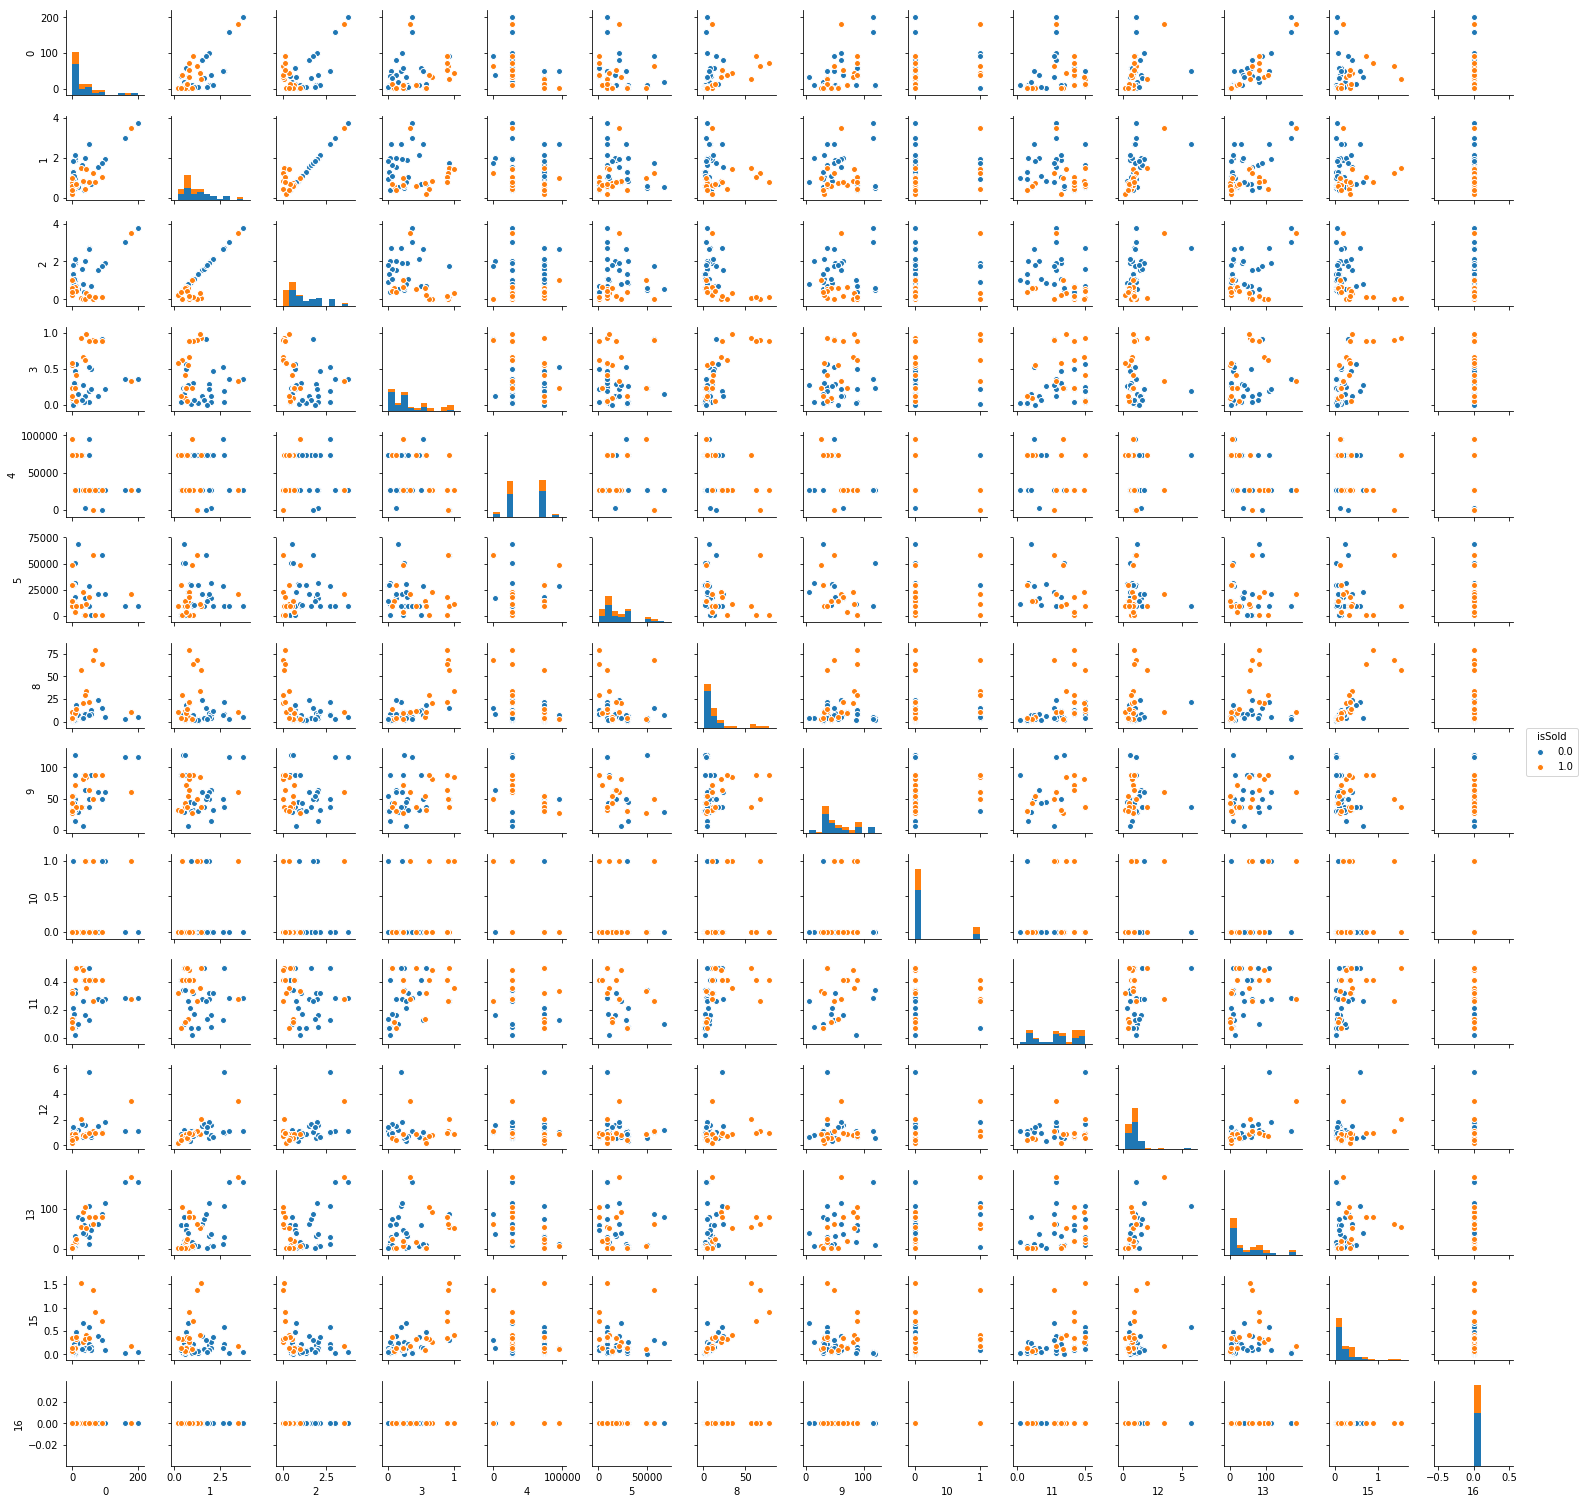

In [18]:
df = DataFrame(np.hstack((train,train_target[:, None])), columns=list(range(n_features)) + ["isSold"])
_=sns.pairplot(df[:50], vars=[0,1,2,3,4,5,8,9,10,11,12,13,15,16], hue="isSold", size=1.5)

In [57]:

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 258588 entries, 0 to 258587
Data columns (total 24 columns):
Price                      258588 non-null float64
PricePercent               258588 non-null float64
StartingBidPercent         258588 non-null float64
SellerClosePercent         258588 non-null float64
Category                   258588 non-null int64
PersonID                   258588 non-null int64
StartingBid                258588 non-null float64
AvgPrice                   258588 non-null float64
HitCount                   258588 non-null int64
AuctionAvgHitCount         258588 non-null int64
ItemAuctionSellPercent     258588 non-null int64
SellerSaleAvgPriceRatio    258588 non-null float64
SellerAvg                  258588 non-null float64
SellerItemAvg              258588 non-null int64
AuctionHitCountAvgRatio    258588 non-null int64
BestOffer                  258588 non-null float64
ReturnsAccepted            258588 non-null int64
IsHOF                      258588 non-

From the plot， No.3 8 12 16 are mixed and unable to distinguish

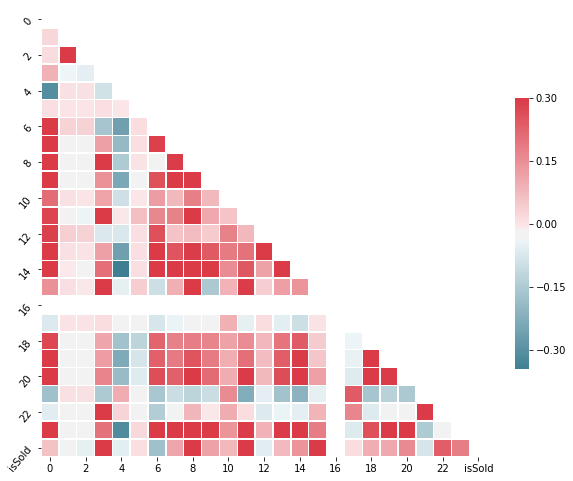

In [49]:
plt.figure(figsize=(10,10))

# corrleation matrix
df.dtypes
#df.drop([df.columns[[8]]], axis=1,inplace=True)
df =df.astype(float)
corr = df.corr()
#print(corr)
mask = np.zeros_like(corr,dtype= np.bool)
mask[np.triu_indices_from(mask)] = True

#print(mask)
 
cmap =sns.diverging_palette(220,10,as_cmap=True)

sns.heatmap(corr,mask=mask,cmap=cmap,vmax=.3,square=True, xticklabels=2, yticklabels=2,
                linewidths=.5, cbar_kws={"shrink":.5})

plt.yticks(rotation =50)
plt.show()



From the bottom line, we can tell the No.3 8 11 15 columns have strong positive relation with 'isSold'

The name of these cloumns are SellerClosePercent，HitCount, SellerSaleAvgPriceRatio and BestOffer

We can drop several columns like No.1 2 16 to continue our training and the name of them are PricePercent StartingBidPercent  ReturnsAccepted

For Price prediction, we will delete No.22 16 17 column           SellerAuctionSaleCount ReturnsAccepted IsHOF

# Stochastic Gradient Descent for Prediction the Success of Auction

C:\Users\TAN\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


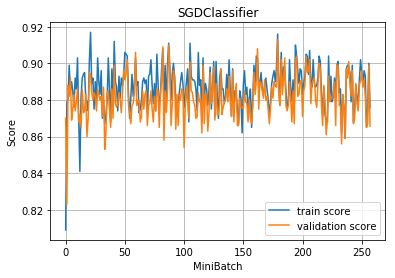

In [58]:
from sklearn.linear_model import  SGDClassifier
from sklearn.preprocessing import StandardScaler

# prepare the data
test_set = pd.read_csv('raw/TestSet.csv')
train_set = pd.read_csv('raw/TrainingSet.csv')

train = train_set.drop(['EbayID','QuantitySold','SellerName','EndDay','PricePercent','StartingBidPercent','ReturnsAccepted'], axis=1)
train_target = train_set['QuantitySold']

n_trainSamples, n_features = train.shape

#choosing different scale of gradient descent batch and draw it

def plot_learning(clf,title):
    plt.figure()
    #score before training
    validationScore =[]
    #score after training 
    trainScore =[]
    #minimum batch of training 
    mini_batch =1000
    
    for idx in range(int(np.ceil(n_trainSamples/mini_batch))):
        x_batch = train[idx * mini_batch: min((idx + 1) * mini_batch, n_trainSamples)]
        y_batch = train_target[idx*mini_batch:min((idx+1)*mini_batch,n_trainSamples)]
        
        if idx>0:
            validationScore.append(clf.score(x_batch,y_batch))
        clf.partial_fit(x_batch,y_batch,classes =range(5))
        if idx >0:
            trainScore.append(clf.score(x_batch,y_batch))
    plt.plot(trainScore,label = "train score")
    
    plt.plot(validationScore,label = "validation score")
    plt.xlabel('MiniBatch')
    plt.ylabel('Score')
    plt.legend('best')
    plt.grid()
    plt.title(title)

scaler = StandardScaler()
train =scaler.fit_transform(train)
#Incremental Learning
clf = SGDClassifier(penalty='l2',alpha=0.001)
plot_learning(clf,"SGDClassifier")

plt.legend()    
plt.show()

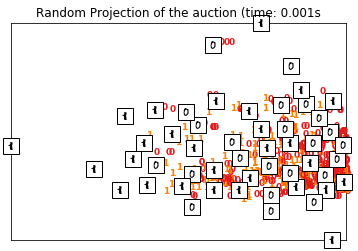

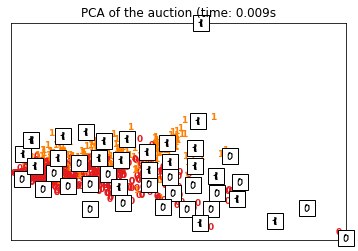

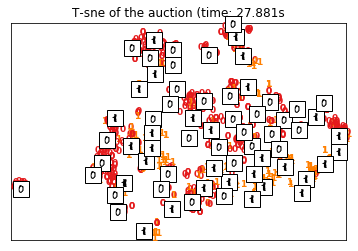

In [21]:
from sklearn import manifold,decomposition,random_projection
from matplotlib import   offsetbox
from time import  time 


images= []
images.append([[  0. ,   0. ,   5. ,  13. ,   9. ,   1. ,   0. ,   0. ],
 [  0. ,   0. ,  13. ,  15. ,  10. ,  15. ,   5. ,   0. ],
 [  0. ,   3. ,  15. ,   2. ,   0. ,  11. ,   8. ,   0. ],
 [  0. ,   4. ,  12. ,   0. ,   0. ,   8. ,   8. ,   0. ],
 [  0. ,   5. ,   8. ,   0. ,   0. ,   9. ,   8. ,   0. ],
 [  0. ,   4. ,  11. ,   0. ,   1. ,  12. ,   7. ,   0. ],
 [  0. ,   2. ,  14. ,   5. ,  10. ,  12. ,   0. ,   0. ],
 [  0. ,   0. ,   6. ,  13. ,  10. ,   0. ,   0. ,   0. ]])

# image[1]为数字1表示某条数据的isSold为1

images.append([[  0. ,   0. ,   0. ,  12. ,  13. ,   5. ,   0. ,   0. ],
 [  0. ,   0. ,   0. ,  11. ,  16. ,   9. ,   0. ,   0. ],
 [  0. ,   0. ,   3. ,  15. ,  16. ,   6. ,   0. ,   0. ],
 [  0. ,   7. ,  15. ,  16. ,  16. ,   2. ,   0. ,   0. ],
 [  0. ,   0. ,   1. ,  16. ,  16. ,   3. ,   0. ,   0. ],
 [  0. ,   0. ,   1. ,  16. ,  16. ,   6. ,   0. ,   0. ],
 [  0. ,   0. ,   1. ,  16. ,  16. ,   6. ,   0. ,   0. ],
 [  0. ,   0. ,   0. ,  11. ,  16. ,  10. ,   0. ,   0. ]])

#print(images[1])

show_instances =1000

def plot_embedding(X,title= None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i,0], X[i,1], str(train_target[i]),
                 color=plt.cm.Set1(train_target[i] / 2.),
                 fontdict={'weight':'bold','size':9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        shown_images = np.array([[1., 1.]])  # just something big
    for i in range(show_instances):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [X[i]]]
        auctionbox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(images[train_target[i]], cmap=plt.cm.gray_r), X[i])
        ax.add_artist(auctionbox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
        
#Random Projection

start_time = time()
rp  = random_projection.SparseRandomProjection(n_components = 2, random_state=42)
rp.fit(train[:show_instances])
train_projected = rp.transform(train[:show_instances])
plot_embedding(train_projected,"Random Projection of the auction (time: %.3fs" % (time() - start_time))

#PCA

start_time = time()
train_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(train[:show_instances])
plot_embedding(train_pca,"PCA of the auction (time: %.3fs" % (time() - start_time))

#T-sne decomposition
start_time = time()
tsne = manifold.TSNE(n_components=2,init='pca',random_state=0)
train_tsne = tsne.fit_transform(train[:show_instances])
plot_embedding(train_tsne,"T-sne of the auction (time: %.3fs" % (time() - start_time))

In [59]:
from sklearn.metrics import (precision_score,recall_score,f1_score)

test = test_set.drop(['EbayID','QuantitySold','SellerName','EndDay','PricePercent','StartingBidPercent','ReturnsAccepted'], axis=1)
test_target = test_set['QuantitySold']
test= scaler.fit_transform(test)


test_pred =clf.predict(test)

print("SGDClassifier training performance on testing dataset:" )
print("\tPrecision: %1.3f " % precision_score(test_target, test_pred))
print("\tRecall: %1.3f" % recall_score(test_target, test_pred))
print("\tF1: %1.3f \n" % f1_score(test_target, test_pred))

SGDClassifier training performance on testing dataset:
	Precision: 0.819 
	Recall: 0.735
	F1: 0.775 



# Using SGD regression for price prediction

C:\Users\TAN\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


SGD regressor prediction result on testing data: 0.983


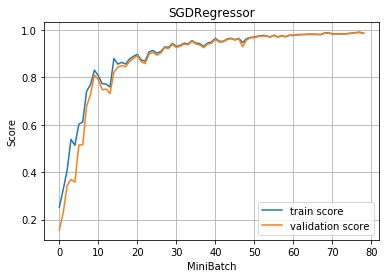

In [61]:
from sklearn.linear_model import SGDRegressor
import random
from sklearn.preprocessing import MinMaxScaler
# prepare the data
train_subset =  pd.read_csv('raw/TrainingSubset.csv')
test_subset = pd.read_csv('raw/TestSubset.csv')

train =  train_subset.drop(['EbayID','QuantitySold','SellerName','EndDay','SellerAuctionSaleCount','IsHOF','ReturnsAccepted'],axis=1)
train_target = train_subset['Price']
#normalization the training data 
scaler = MinMaxScaler()
train = scaler.fit_transform(train)

n_trainSamples,n_features = train.shape

#Incremental Learning
def plot_learning(clf,title):
    plt.figure()
    #score before training
    validationScore =[]
    #score after training 
    trainScore =[]
    #minimum batch of training 
    mini_batch =1000
    
    for idx in range(int(np.ceil(n_trainSamples/mini_batch))):
        x_batch = train[idx * mini_batch: min((idx + 1) * mini_batch, n_trainSamples)]
        y_batch = train_target[idx*mini_batch:min((idx+1)*mini_batch,n_trainSamples)]
        
        if idx>0:
            validationScore.append(clf.score(x_batch,y_batch))
        clf.partial_fit(x_batch,y_batch)
        if idx >0:
            trainScore.append(clf.score(x_batch,y_batch))
    plt.plot(trainScore,label = "train score")
    plt.plot(validationScore,label = "validation score")
    plt.xlabel('MiniBatch')
    plt.ylabel('Score')
    plt.legend('best')
    plt.grid()
    plt.title(title)
#  SGDregression
sgd_regresor = SGDRegressor(penalty ='l2',alpha =0.0001)
plot_learning(sgd_regresor,'SGDRegressor')    
test =test_subset.drop(['EbayID','QuantitySold','SellerName','EndDay','SellerAuctionSaleCount','IsHOF','ReturnsAccepted'],axis=1)
test_target = test_subset['Price']
test =scaler.fit_transform(test)

print("SGD regressor prediction result on testing data: %.3f" % sgd_regresor.score(test,test_target))

plt.legend()
plt.show()

The score is 0.983 which is much better than training with these items